<a href="https://colab.research.google.com/github/ndb796/Decision-based-Attacks-PyTorch/blob/main/Targeted_HopSkipJump_Attack_for_CelebA_Identity_Classification_Using_PyTorch_Foolbox_with_Determined_Targets_(Correctly_Classified_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <b>Dataset Download</b>

<pre>
<b>Dataset/</b>
    <b>test/</b>
        identity 1/
        identity 2/
        ...
</pre>

In [1]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EW5XzDm1pNVIgsoADwSmclsBS_FXWMA82NlL_0YiRTVeMg?download=1 -O determined_corrected_facial_identity_latent_vectors.zip
!unzip determined_corrected_facial_identity_latent_vectors.zip -d ./determined_corrected_facial_identity_latent_vectors

### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [3]:
# ref: https://chsasank.github.io/vision/_modules/torchvision/datasets/folder.html
from PIL import Image
import os
import os.path
from torch.utils.data import Dataset


def is_png_file(filename):
    return any(filename.endswith(extension) for extension in ['.png'])


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    global class_to_idx
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx):
    processed = set()
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_png_file(fname):
                    path = os.path.join(root, fname).split('.png')[0][:-4]
                    temp = os.listdir(path.split('img')[0])
                    for di in temp:
                        if 'trg_' in di and 'img' + path.split('img')[1] in di:
                            target_label = di.split('trg_')[1].split('.npy')[0]
                    if path in processed:
                        continue
                    processed.add(path)
                    item = (path + '.ori.png', path + '.ori.npy', class_to_idx[target], path + '.trg.png', path + f'.trg_{target_label}.npy', class_to_idx[target_label])
                    images.append(item)

    return images


def numpy_loader(path):
    return np.load(path)


def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


class LatentFolder(Dataset):
    def __init__(self, root, target_transforms):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx)

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.numpy_loader = numpy_loader
        self.pil_loader = pil_loader
        self.target_transforms = target_transforms

    def __getitem__(self, index):
        img, npy, label, trg_img, trg_npy, target_label = self.imgs[index]
        img = self.pil_loader(img)
        img = self.target_transforms(img)
        trg_img = self.pil_loader(trg_img)
        trg_img = self.target_transforms(trg_img)
        npy = self.numpy_loader(npy)
        npy = torch.from_numpy(npy)
        trg_npy = self.numpy_loader(trg_npy)
        trg_npy = torch.from_numpy(trg_npy)
        return img, npy, label, trg_img, trg_npy, target_label

    def __len__(self):
        return len(self.imgs)

In [4]:
transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

data_dir = './determined_corrected_facial_identity_latent_vectors/determined_corrected_facial_identity_latent_vectors'

test_dataset = LatentFolder(os.path.join(data_dir), transforms_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
print('Test dataset size:', len(test_dataset))

class_names = test_dataset.classes
print('Class names:', class_names)

Test dataset size: 191
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '223', '226', '228', '230', '

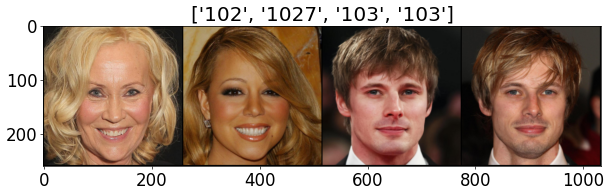

In [5]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(test_dataloader)

# visualize a batch of train image
inputs, npys, classes, _, _, _ = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Load Pre-trained Model</b>

In [6]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EeIlxtZtQIdFhRCUkCBSaIQBBbP5dujTUpRNtj8TRinRaQ?download=1 -O facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth

--2021-03-17 18:00:52--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EeIlxtZtQIdFhRCUkCBSaIQBBbP5dujTUpRNtj8TRinRaQ?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 40.108.156.33
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|40.108.156.33|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/CelebA%20HQ/facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FZUlseHRadFFJZEZoUkNVa0NCU2FJUUJCYlA1ZHVqVFVwUk50ajhUUmluUmFRP3J0aW1lPUxmd05tMjdwMkVn [following]
--2021-03-17 18:00:53--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/CelebA%20HQ/facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pt

In [23]:
save_path = 'facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
model.load_state_dict(torch.load(save_path))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
# input data normalization class
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [25]:
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # add an input normalization layer
    model
).to(device).eval()

### <b>Test Phase</b>

[Prediction Result Examples]


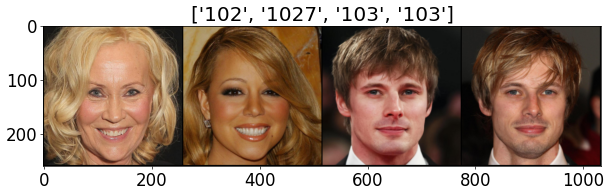

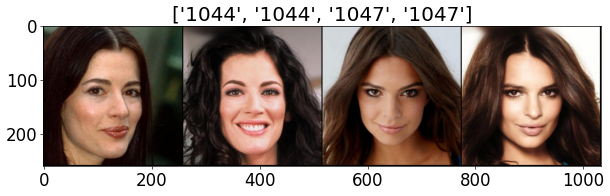

[Test] Loss: 0.0236 Acc: 100.0000% Time: 1.8712s


In [26]:
criterion = nn.CrossEntropyLoss()

model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, npys, labels, target_inputs, target_npys, target_labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

[Prediction Result Examples]


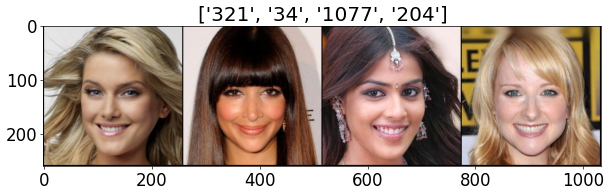

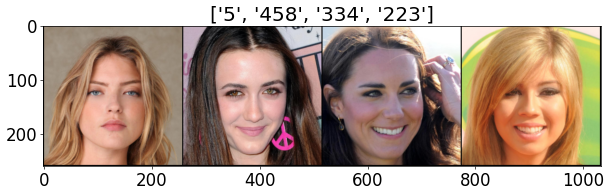

[Test] Loss: 0.0173 Acc: 100.0000% Time: 1.8473s


In [27]:
criterion = nn.CrossEntropyLoss()

model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, npys, labels, target_inputs, target_npys, target_labels) in enumerate(test_dataloader):
        target_inputs = target_inputs.to(device)
        target_labels = target_labels.to(device)

        outputs = model(target_inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, target_labels)

        running_loss += loss.item() * target_inputs.size(0)
        running_corrects += torch.sum(preds == target_labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(target_inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in target_labels[:4]])
            images = torchvision.utils.make_grid(target_inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in target_labels[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

#### <b>Prepare Adversarial Attack Libraries</b>

In [28]:
!pip install eagerpy
!pip install gitpython

In [29]:
!git clone https://github.com/ndb796/Foolbox-Decision-based-Attack-Baseline
!cp -r ./Foolbox-Decision-based-Attack-Baseline/* ./

fatal: destination path 'Foolbox-Decision-based-Attack-Baseline' already exists and is not an empty directory.


In [30]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

#### <b>Adversarial Attack Example 1</b>

* <b>Attack method</b>: HopSkipJump Attack
* <b>Images</b>: All test images

In [31]:
import random

random.seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[Attack start for one batch]
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.5689, 0.4927, 0.4025, 0.5749, 0.6959, 0.5979, 0.6609, 0.7165],
                     device='cuda:0'))
Binary step count: 27
Gradient step count: 100
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.8988, 0.9152, 0.9576, 0.9531, 0.8988, 0.9110, 0.9414, 0.9861],
                     device='cuda:0'))
Binary step count: 26
Gradient step count: 141
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.9061, 0.9803, 0.9776, 0.9641, 0.8565, 0.9028, 0.9448, 0.9918],
                     device='cuda:0'))
Binary step count: 26
Gradient step count: 173
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.8901, 0.9893, 0.9448, 0.9388, 0.8331, 0.9619, 0.9348, 0.9641],
                     device='cuda:0'))
Binary step count: 26
[Attack finished] (query count: 328 

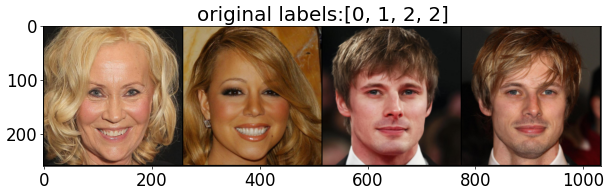

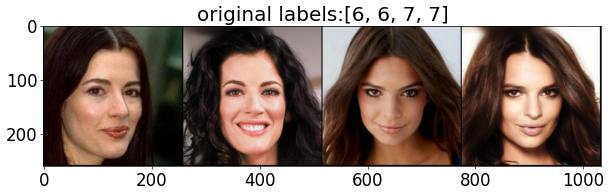

[Start Image Examples]


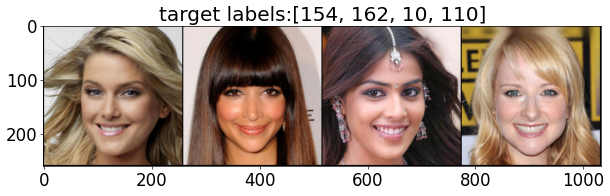

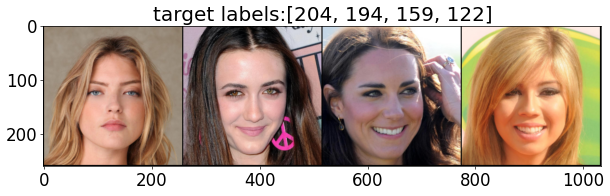

[Attack Result Examples]


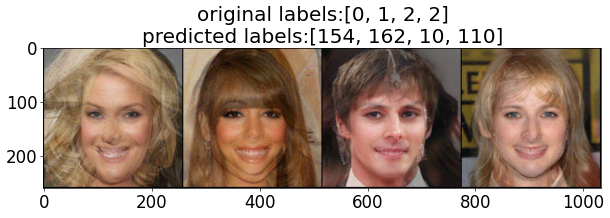

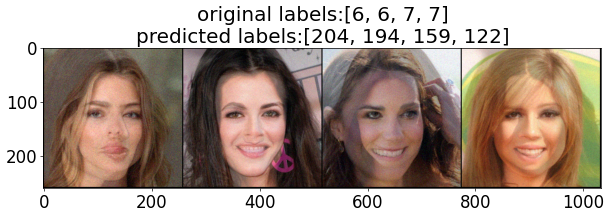

[Step #0] Loss: 0.6917 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 5.4235s (total 8 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196576.25
Average L2 distance: 76.86033630371094
Average MSE (from Start): 0.025369977578520775
Average MSE: 0.03282502293586731
Average Linf distance (the maximum changed values): 0.561173677444458
[Attack start for one batch]
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.4551, 0.6575, 0.7308, 0.6161, 0.4631, 0.6088, 0.5074, 0.7934],
                     device='cuda:0'))
Binary step count: 27
Gradient step count: 100
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.8886, 0.9044, 0.9377, 0.9601, 0.9766, 0.9576, 0.9546, 0.9664],
                     device='cuda:0'))
Binary step count: 26
Gradient step count: 141
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.8108, 0.828

In [32]:
%autoreload 2

import time
from foolbox import criteria
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.HopSkipJump(init_attack=None, steps=100,
                                # initial_gradient_eval_steps=100, max_gradient_eval_steps=10000,
                                query_limit=500)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_mse_from_start = 0
running_linf = 0

for i, (inputs, npys, labels, target_inputs, target_npys, target_labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    starting_points = target_inputs.to(device)
    target_labels = target_labels.to(device)

    attack_criterion = criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_mse_from_start += (adv_targeted - starting_points).view(adv_targeted.shape[0], -1).pow(2).mean(1).sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

        print('[Size of Perturbation]')
        print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
        print('Average L2 distance:', running_l2 / running_length)
        print('Average MSE (from Start):', running_mse_from_start / running_length)
        print('Average MSE:', running_mse / running_length)
        print('Average Linf distance (the maximum changed values):', running_linf / running_length)

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE (from Start):', running_mse_from_start / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 2</b>

* <b>Attack method</b>: HopSkipJump Attack
* <b>Images</b>: All test images

[Attack start for one batch]
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.5689, 0.4927, 0.4025, 0.5749, 0.6959, 0.5979, 0.6609, 0.7165],
                     device='cuda:0'))
Binary step count: 27
Gradient step count: 100
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.8644, 0.8440, 0.9614, 0.9322, 0.8438, 0.9000, 0.8850, 0.9934],
                     device='cuda:0'))
Binary step count: 26
Gradient step count: 141
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.8809, 0.9858, 0.9575, 0.9642, 0.8357, 0.9577, 0.8953, 0.9362],
                     device='cuda:0'))
Binary step count: 26
Gradient step count: 173
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.9031, 0.9777, 0.9562, 0.9903, 0.9690, 0.9048, 0.8736, 0.9917],
                     device='cuda:0'))
Binary step count: 26
Gradient step count: 200
Reached num

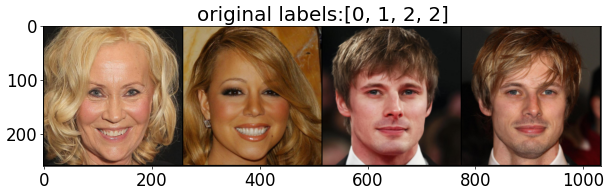

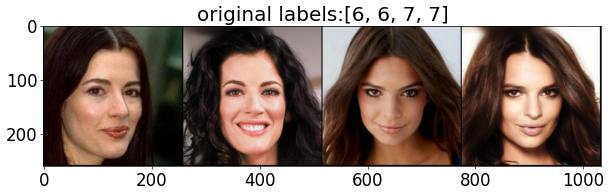

[Start Image Examples]


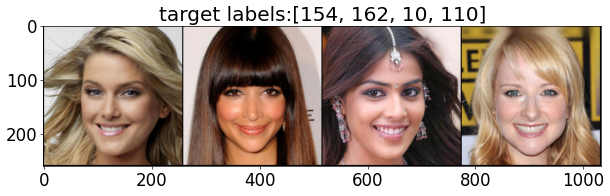

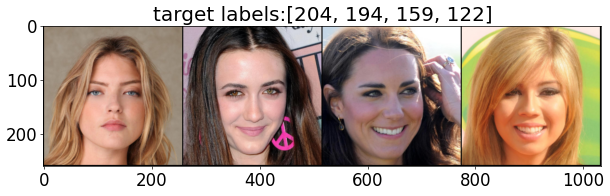

[Attack Result Examples]


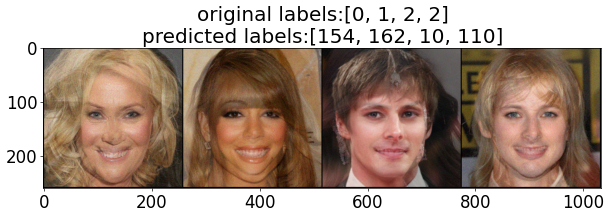

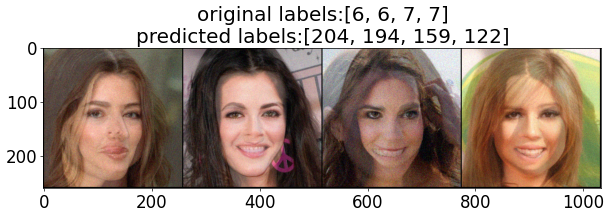

[Step #0] Loss: 0.4676 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 8.7067s (total 8 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196556.125
Average L2 distance: 66.47146606445312
Average MSE (from Start): 0.03350553661584854
Average MSE: 0.024919265881180763
Average Linf distance (the maximum changed values): 0.49835729598999023
[Attack start for one batch]
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.4551, 0.6575, 0.7308, 0.6161, 0.4631, 0.6088, 0.5074, 0.7934],
                     device='cuda:0'))
Binary step count: 27
Gradient step count: 100
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.8235, 0.9273, 0.9210, 0.8954, 0.9333, 0.8756, 0.9646, 0.9667],
                     device='cuda:0'))
Binary step count: 26
Gradient step count: 141
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.8155, 0.

In [33]:
%autoreload 2

import time
from foolbox import criteria
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.HopSkipJump(init_attack=None, steps=100,
                                # initial_gradient_eval_steps=100, max_gradient_eval_steps=10000,
                                query_limit=1000)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_mse_from_start = 0
running_linf = 0

for i, (inputs, npys, labels, target_inputs, target_npys, target_labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    starting_points = target_inputs.to(device)
    target_labels = target_labels.to(device)

    attack_criterion = criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_mse_from_start += (adv_targeted - starting_points).view(adv_targeted.shape[0], -1).pow(2).mean(1).sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

        print('[Size of Perturbation]')
        print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
        print('Average L2 distance:', running_l2 / running_length)
        print('Average MSE (from Start):', running_mse_from_start / running_length)
        print('Average MSE:', running_mse / running_length)
        print('Average Linf distance (the maximum changed values):', running_linf / running_length)

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE (from Start):', running_mse_from_start / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 3</b>

* <b>Attack method</b>: HopSkipJump Attack
* <b>Images</b>: All test images

[Attack start for one batch]
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.5689, 0.4927, 0.4025, 0.5749, 0.6959, 0.5979, 0.6609, 0.7165],
                     device='cuda:0'))
Binary step count: 27
Gradient step count: 100
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.9147, 0.8597, 0.9564, 0.9621, 0.8463, 0.9271, 0.9856, 0.9668],
                     device='cuda:0'))
Binary step count: 26
Gradient step count: 141
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.9077, 0.9769, 0.9522, 0.9951, 0.8285, 0.9050, 0.8907, 0.9355],
                     device='cuda:0'))
Binary step count: 26
Gradient step count: 173
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.8824, 0.9473, 0.9659, 0.9280, 0.9277, 0.9498, 0.7790, 0.9870],
                     device='cuda:0'))
Binary step count: 26
Gradient step count: 200
Reached num

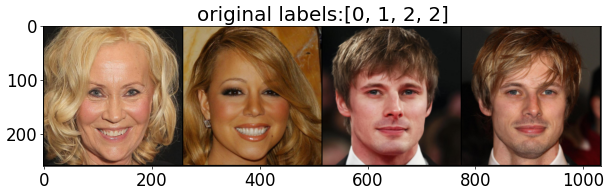

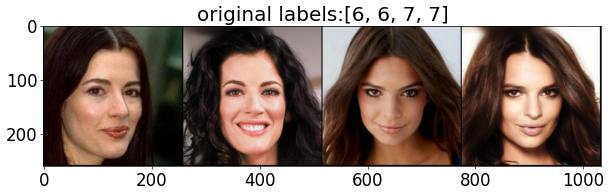

[Start Image Examples]


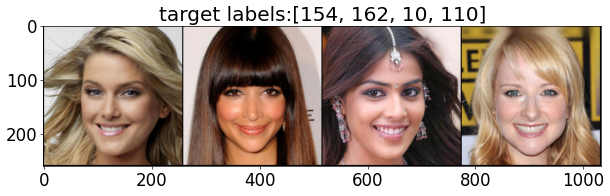

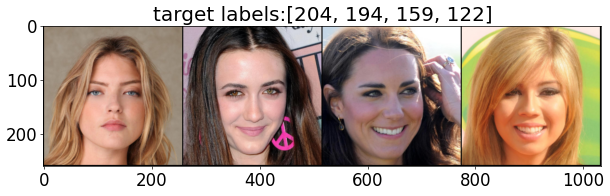

[Attack Result Examples]


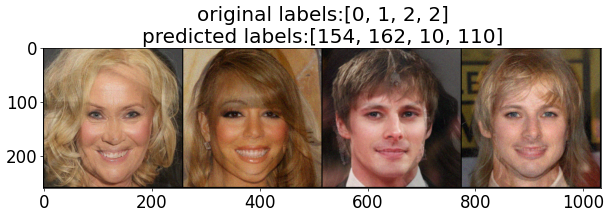

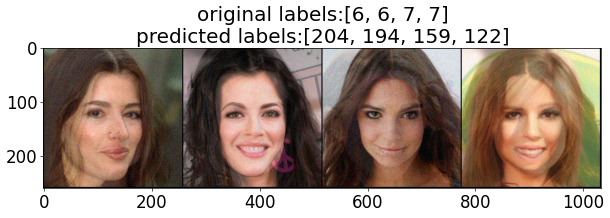

[Step #0] Loss: 0.3873 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 17.6502s (total 8 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196568.125
Average L2 distance: 51.40341567993164
Average MSE (from Start): 0.04785509780049324
Average MSE: 0.015557458624243736
Average Linf distance (the maximum changed values): 0.4006613790988922
[Attack start for one batch]
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.4551, 0.6575, 0.7308, 0.6161, 0.4631, 0.6088, 0.5074, 0.7934],
                     device='cuda:0'))
Binary step count: 27
Gradient step count: 100
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.8186, 0.8982, 0.9238, 0.9149, 0.9332, 0.9243, 0.9465, 0.9670],
                     device='cuda:0'))
Binary step count: 26
Gradient step count: 141
Reached numerical precision!
Binary step ratio (up to 8 examples): PyTorchTensor(tensor([0.8744, 0.

In [34]:
%autoreload 2

import time
from foolbox import criteria
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.HopSkipJump(init_attack=None, steps=100,
                                # initial_gradient_eval_steps=100, max_gradient_eval_steps=10000,
                                query_limit=2000)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_mse_from_start = 0
running_linf = 0

for i, (inputs, npys, labels, target_inputs, target_npys, target_labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    starting_points = target_inputs.to(device)
    target_labels = target_labels.to(device)

    attack_criterion = criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_mse_from_start += (adv_targeted - starting_points).view(adv_targeted.shape[0], -1).pow(2).mean(1).sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(inputs[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(inputs[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

        print('[Size of Perturbation]')
        print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
        print('Average L2 distance:', running_l2 / running_length)
        print('Average MSE (from Start):', running_mse_from_start / running_length)
        print('Average MSE:', running_mse / running_length)
        print('Average Linf distance (the maximum changed values):', running_linf / running_length)

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE (from Start):', running_mse_from_start / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)